## Upload dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PC1.arff to PC1.arff


## Install new version of scikit-learn

In [2]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 1.5 MB/s 


## Import required libraries

In [27]:
from scipy.io.arff import loadarff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

## Load dataset

In [28]:
raw_data = loadarff("PC1.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,1.0,3.0,2.0,0.0,0.0,4.0,2.0,0.40,2.0,2.0,2.0,1.00,8.0,1.0,0.0,5.0,0.0,11.20,7.50,630.00,0.03,21.0,0.13,35.00,84.00,0.50,1.0,2.0,8.0,0.29,9.0,12.0,6.0,10.0,7.0,0.00,5.0,0
1,2.0,5.0,2.0,1.0,3.0,8.0,3.0,0.21,4.0,2.0,1.0,0.33,12.0,1.0,0.0,13.0,1.0,17.50,12.50,2734.06,0.07,46.0,0.08,151.89,218.72,0.33,2.0,4.0,11.0,0.15,20.0,26.0,12.0,15.0,20.0,23.53,14.0,1
2,0.0,3.0,1.0,0.0,0.0,4.0,2.0,0.14,2.0,2.0,2.0,1.00,5.0,1.0,0.0,14.0,1.0,20.76,12.27,3126.53,0.08,58.0,0.08,173.70,254.75,0.50,1.0,2.0,5.0,0.13,27.0,31.0,11.0,10.0,15.0,0.00,14.0,0
3,2.0,3.0,2.0,0.0,0.0,4.0,2.0,0.10,2.0,2.0,2.0,1.00,7.0,1.0,0.0,20.0,1.0,32.81,7.76,1978.37,0.08,53.0,0.13,109.91,254.79,0.50,1.0,2.0,7.0,0.09,24.0,29.0,17.0,11.0,23.0,0.00,20.0,0
4,19.0,17.0,13.0,0.0,0.0,4.0,15.0,0.27,2.0,2.0,14.0,0.93,35.0,1.0,0.0,55.0,1.0,48.69,19.67,18831.94,0.32,159.0,0.05,1046.22,957.56,0.07,1.0,2.0,22.0,0.20,59.0,100.0,39.0,26.0,75.0,0.00,55.0,0


## Model Training and Testing without Feature Selection

In [29]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [30]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9198113207547169

### Naive Bayes

In [31]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.8820754716981132

### Decision Tree

In [32]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8773584905660378

### Random Forest

In [33]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.910377358490566

### AdaBoost

In [34]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc.score(X_test, y_test)

0.8820754716981132

## Correlation Matrix of Dataset

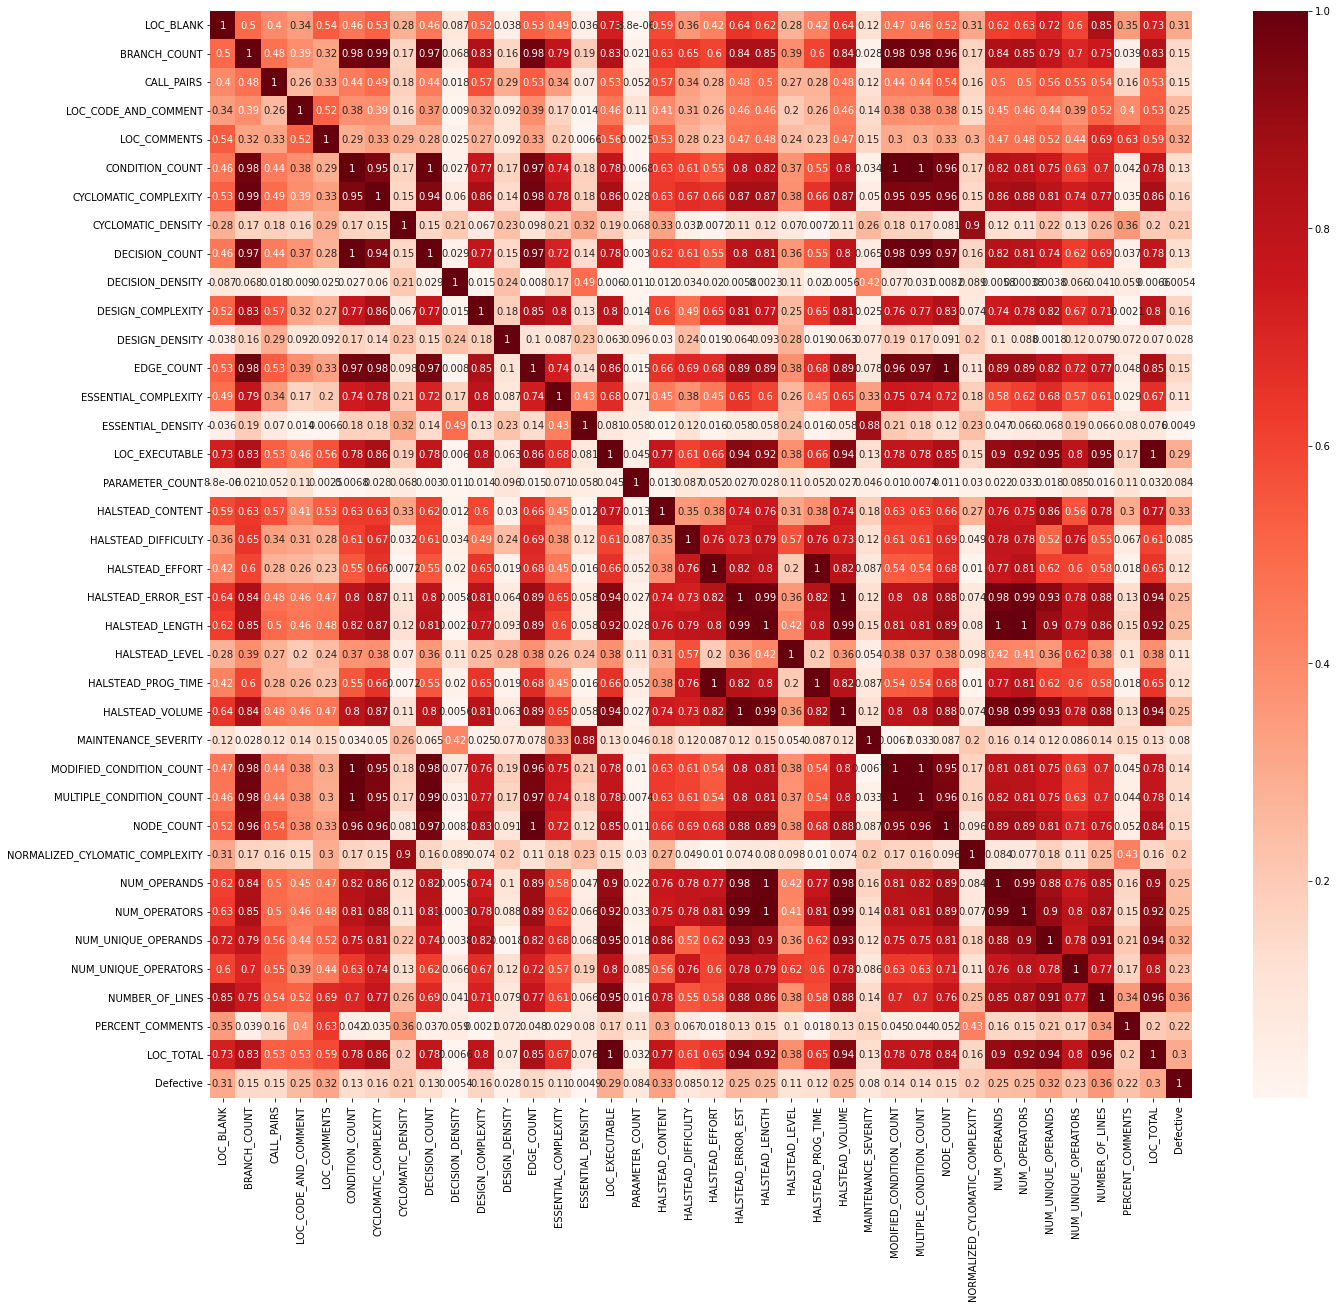

In [35]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [36]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(np.bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'EDGE_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUMBER_OF_LINES', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,PERCENT_COMMENTS,Defective
0,1.0,3.0,2.0,0.0,0.0,0.40,2.0,2.0,1.00,1.0,0.0,5.0,0.0,11.20,7.50,630.00,0.03,0.13,0.50,0.29,6.0,10.0,0.00,0
1,2.0,5.0,2.0,1.0,3.0,0.21,2.0,1.0,0.33,1.0,0.0,13.0,1.0,17.50,12.50,2734.06,0.07,0.08,0.33,0.15,12.0,15.0,23.53,1
2,0.0,3.0,1.0,0.0,0.0,0.14,2.0,2.0,1.00,1.0,0.0,14.0,1.0,20.76,12.27,3126.53,0.08,0.08,0.50,0.13,11.0,10.0,0.00,0
3,2.0,3.0,2.0,0.0,0.0,0.10,2.0,2.0,1.00,1.0,0.0,20.0,1.0,32.81,7.76,1978.37,0.08,0.13,0.50,0.09,17.0,11.0,0.00,0
4,19.0,17.0,13.0,0.0,0.0,0.27,2.0,14.0,0.93,1.0,0.0,55.0,1.0,48.69,19.67,18831.94,0.32,0.05,0.07,0.20,39.0,26.0,0.00,0


In [37]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [39]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
knn.score(X_test_sfs, y_test)

0.9198113207547169

Selected features for KNN

In [40]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY'],
      dtype='object')

### Naive Bayes

In [41]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
gnb.score(X_test_sfs, y_test)

0.9056603773584906

Selected features for Naive Bayes

In [42]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'DECISION_DENSITY',
       'DESIGN_DENSITY', 'ESSENTIAL_DENSITY', 'PARAMETER_COUNT',
       'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST',
       'HALSTEAD_LEVEL', 'MAINTENANCE_SEVERITY'],
      dtype='object')

### Decision Tree

In [43]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
dtc.score(X_test_sfs, y_test)

0.8537735849056604

Selected features for Decision Tree

In [44]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'DECISION_DENSITY', 'ESSENTIAL_COMPLEXITY', 'PARAMETER_COUNT',
       'HALSTEAD_ERROR_EST', 'NORMALIZED_CYLOMATIC_COMPLEXITY',
       'NUM_UNIQUE_OPERATORS', 'PERCENT_COMMENTS'],
      dtype='object')

### Random Forest

In [45]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
rfc.score(X_test_sfs, y_test)

0.9150943396226415

Selected features for Random Forest

In [46]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'ESSENTIAL_DENSITY',
       'PARAMETER_COUNT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_LEVEL',
       'PERCENT_COMMENTS'],
      dtype='object')

### AdaBoost

In [47]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
abc.score(X_test_sfs, y_test)

0.9056603773584906

Selected features for AdaBoost

In [48]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'HALSTEAD_ERROR_EST',
       'NORMALIZED_CYLOMATIC_COMPLEXITY'],
      dtype='object')